<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Reinforcement Learning

## OpenAI Gym

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## MountainCar

In [ ]:
!git clone https://github.com/tpq-classes/rl_for_finance.git
import sys
sys.path.append('rl_for_finance')


In [ ]:
import gymnasium as gym
import random
import numpy as np
import pandas as pd
from pylab import plt

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython import display
plt.ion()
plt.style.use('seaborn-v0_8')
from collections import deque
import warnings; warnings.simplefilter('ignore')

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

## Environment

See https://gym.openai.com/envs/MountainCar-v0/ and https://github.com/openai/gym/wiki/MountainCar-v0.

In [ ]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

## Action Space

In [ ]:
env.action_space  # type of action space

Discrete(3)

In [ ]:
env.action_space.n  # number of discrete actions

3

In [ ]:
env.action_space.sample()  # sample action

2

In [ ]:
env.action_space.sample()  # sample action

2

In [ ]:
[env.action_space.sample() for _ in range(10)]

[2, 0, 2, 0, 1, 2, 2, 2, 0, 1]

## Observation Space

In [ ]:
np.set_printoptions(precision=4, suppress=True)

In [ ]:
env.observation_space  # type of observation space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [ ]:
env.observation_space.high.astype(np.float16) # upper bounds for observations

array([0.6 , 0.07], dtype=float16)

In [ ]:
env.observation_space.low.astype(np.float16)  # lower bounds for observations

array([-1.2 , -0.07], dtype=float16)

In [ ]:
o = env.reset()
o  # [position, velocity]

(array([-0.5742,  0.    ], dtype=float32), {})

## Taking Action

The following visualizes the effect of a number of random actions taken. See https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885

In [ ]:
a = env.action_space.sample()  # random action
a

1

In [ ]:
r = env.step(a)  # taking action, capturing new observations
r  # (observation, reward, done, info)

(array([-0.5738,  0.0004], dtype=float32), -1.0, False, False, {})

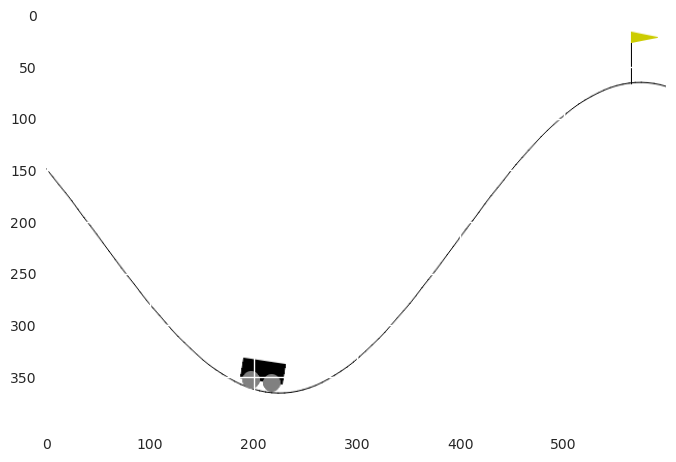

In [ ]:
env.reset()
img = plt.imshow(env.render()) # initialize bitmap embedding
for e in range(151):
    img.set_data(env.render()) # updating the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    a = env.action_space.sample()  # random action choice
    # a = 2  # constant action choice
    obs, rew, done, _, _ = env.step(a)  # taking action
    if done and (e + 1) < 200:
        print('*** FAILED ***')
        break

## Setting Seeds

In [ ]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.action_space.seed(seed)

## Q Learning

In [ ]:
class DQLAgent:
    def __init__(self):
        self.epsilon = 1.0  # initial epsilon
        self.epsilon_min = 0.01  # minimal epsilon
        self.epsilon_decay = 0.995  # epsilon decay
        self.gamma = 0.95  # discount factor
        self.batch_size = 128  # batch size for replay
        self.max_treward = -1e6
        self.averages = list()
        self.memory = deque(maxlen=2000)  # fixed memory
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(128, activation='relu'))
        # multiple labels, discrete actions
        # estimation problem (activation is linear)
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model(tf.convert_to_tensor(state, dtype=tf.float32), training=False).numpy()
        return np.argmax(action)  # choose action with highest value

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            # reward design
            position = state[0, 0]
            reward_ = position + 0.5  # base reward relative to success
            # if position <= -0.5:  # does not work ...
            #    reward_ -= 1  # penalty for positions on the left
            if position >= self.max_position:
                self.max_position = position
                reward_ += 1  # reward for new max position to the right
                if self.max_position > self.max_pos:
                    self.max_pos = self.max_position  # update of max position
            if position >= 0.5:
                reward_ += 100  # high reward for success
            # Q-learning
            if not done:
                reward_ += self.gamma * np.amax(
                    self.model(tf.convert_to_tensor(next_state, dtype=tf.float32), training=False).numpy())
            target = self.model(tf.convert_to_tensor(state, dtype=tf.float32), training=False).numpy()
            target[0, action] = reward_
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        trewards = []
        self.positions = []
        self.max_pos = -0.4
        for e in range(1, episodes + 1):
            state,_ = env.reset()
            state = np.reshape(state, [1, self.osn])
            treward = 0
            self.max_position = -0.4
            for i in range(5000):
                action = self.act(state)
                next_state, reward, done, trunc, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                treward += float(reward)
                position = state[0, 0]
                if done or position >= 0.5:
                    trewards.append(treward)
                    self.positions.append(position)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:7.1f} | '
                    templ += 'av: {:7.1f} | max_r: {:7.1f} | '
                    templ += 'max_p: {:4.2f} | pos: {:4.2f}'
                    print(templ.format(e, episodes, treward, av,
                            self.max_treward, self.max_pos, position), end='\r')
                    break
            if len(self.memory) > self.batch_size:
                    self.replay()
            if position >= 0.5:
                break
        print()

    def test(self, episodes):
        rewards = []
        positions = []
        for e in range(1, episodes + 1):
            state = env.reset()
            treward = 0
            for _ in range(1001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model(tf.convert_to_tensor(state, dtype=tf.float32), training=False).numpy())
                next_state, reward, done, trunc, info = env.step(action)
                state = next_state
                treward += reward
                if done or state[0] >= 0.5:
                    rewards.append(treward)
                    positions.append(state[0])
                    print('episode: {:4d}/{} | treward: {:7.1f} | position {:4.3f}'
                          .format(e, episodes, treward, state[0]), end='\r')
                    break
        return rewards, positions

In [ ]:
set_seeds(100)
agent = DQLAgent()

ModuleNotFoundError: No module named 'keras.api._v2'

In [ ]:
episodes = 250 # 750

In [ ]:
%time agent.learn(episodes)

In [ ]:
agent.epsilon

In [ ]:
agent.max_pos

In [ ]:
agent.positions

In [ ]:
plt.figure(figsize=(10, 6))
x = range(len(agent.positions))
y = np.polyval(np.polyfit(x, agent.positions, deg=3), x)
plt.plot(agent.positions, label='final position')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('position value')
plt.legend();

## Testing the Agent

In [ ]:
trewards, positions = agent.test(100)

In [ ]:
sum(positions) / len(positions)

In [ ]:
seeds = list()
for seed in range(0, 10000, 100):
    env.seed(seed)
    state = env.reset()
    for e in range(201):
        state = np.reshape(state, [1, agent.osn])
        a = np.argmax(agent.model(tf.convert_to_tensor(state, dtype=tf.float32), training=False).numpy())  # learned action
        state, reward, done, info = env.step(a)
        if done and e >= 199:
            print(f'*** FAILED *** ({seed} | {e})', end='\r')
            break
        elif done and e < 199:
            print(f'*** FINISHED *** ({seed} | {e})', end='\r')
            seeds.append((seed, e))
            break

In [ ]:
seeds[:5]

In [ ]:
env.seed(1000)
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # initialize bitmap embedding
for e in range(201):
    img.set_data(env.render(mode='rgb_array')) # updating the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state = np.reshape(state, [1, agent.osn])
    a = np.argmax(agent.model(tf.convert_to_tensor(state, dtype=tf.float32), training=False).numpy())  # learned action
    state, reward, done, info = env.step(a)
    if done and (e + 1) < 200:
        print(f'*** SUCCESS {e} ***')
        break
    elif done:
        print('*** FAILED ***')
        break

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>